<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required librairies</a>  
- <a href='#setting_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the Jump Translational diffusion model `JumpTranslationalDiffusion` to perform some fits using [bumps](https://github.com/bumps/bumps).
</div>

Example of fit to model generated data corresponding to a 
Jump Translational diffusion model with self-diffusion 
coefficient, $D$ equal to 0.145 AA$^2\times$meV and residence time 1.0 meV$^-1$.

The model is convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

The data do not have a background.

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [3]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps

 (<a href='#Table of Contents'>Top</a>)<a id='setting_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

These settings are saved in a Python script, which will be used by Bumps to run the fit.

In [5]:
# Name of Python script containing the model
model_file = "model_fit_JumpTranslationalDiffusion.py"

In [6]:
%%writefile $model_file
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *

path_to_data = './data/'

# Read the sample
f = h5py.File(path_to_data + 'JumpDiff_Sample.hdf', 'r')
hw = f['entry1']['data1']['X'][:]
q = f['entry1']['data1']['Y'][:]
sqw = np.transpose(f['entry1']['data1']['DATA'][:])
err = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Read resolution
f = h5py.File(path_to_data + 'JumpDiff_Resol.hdf', 'r')
res = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   

# Fitting model 
def model_convol(x, q, scale=1, center=0, D=1, resTime=1, resolution=None):
    model = QENSmodels.sqwJumpTranslationalDiffusion(x, q, scale, center, D, resTime)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

for i in range(len(q)):

    # Bumps fitting model
    Mq = Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, D=0.1, resTime=0.5, resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1, 0.1)
    Mq.D.range(0, 1)
    Mq.resTime.range(0, 5)
    
    # Q-independent parameters
    if i == 0:
        QD = Mq.D
        QT = Mq.resTime
    else:
        Mq.D = QD
        Mq.resTime = QT
    M.append(Mq)
        
problem = FitProblem(M)

Overwriting model_fit_JumpTranslationalDiffusion.py


<h3> Choice of minimizer for bumps </h3>

In [7]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

Dropdown(description=u'Minimizer:', index=4, options={'Quasi-Newton BFGS': 'newton', 'Random Lines (experimental)': 'rl', 'Parallel Tempering (experimental)': 'pt', 'Particle Swarm (experimental)': 'ps', 'Levenberg-Marquardt': 'lm', 'Differential Evolution': 'de', 'Nelder-Mead Simplex': 'amoeba', 'DREAM': 'dream'}, value='lm')

<h3> Setting for running bumps </h3>

In [8]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

# output folder to save thre results
output_folder = 'QENS'

(<a href='#Table of Contents'>Top</a>)<a id='running_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above
The subfolder *output_folder* contains different results: plots and 
refined parameters

# /Users/celinedurniak/anaconda/envs/aseenv/lib/python2.7/site-packages/bumps/cli.py model_fit_JumpTranslationalDiffusion.py --fit=lm --steps=100 --store=QENS
-- Model 0 
.D = Parameter(0.1, name='D', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.q = Parameter(0.2, name='q')
.resTime = Parameter(0.5, name='resTime', bounds=(0,5))
.scale = Parameter(1000, name='scale', bounds=(0,100000))

[chisq=2411.367(12), nllf=483479]
-- Model 1 
.D = Parameter(0.1, name='D', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.q = Parameter(0.4, name='q')
.resTime = Parameter(0.5, name='resTime', bounds=(0,5))
.scale = Parameter(1000, name='scale', bounds=(0,100000))

[chisq=1179.453(12), nllf=236480]
-- Model 2 
.D = Parameter(0.1, name='D', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.q = Parameter(0.6, name='q')
.resTime = Parameter(0.5, name='resTime', bounds=(0,5))
.scale = Parameter(1000, name='scale', bounds=(0,100000))


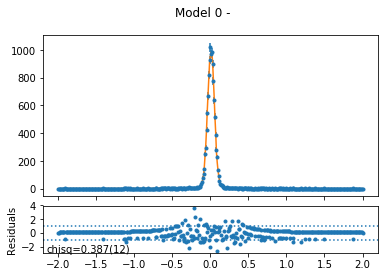

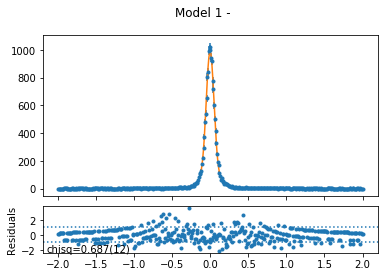

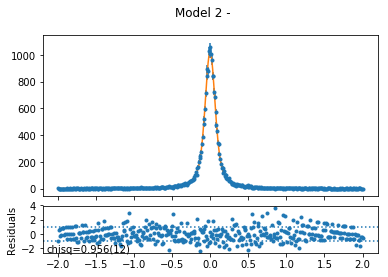

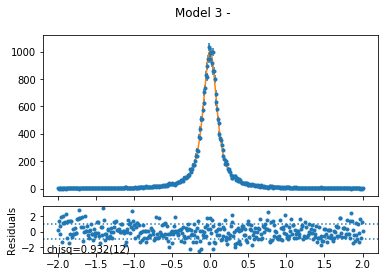

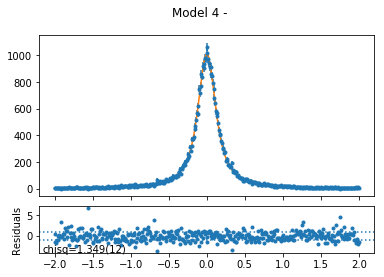

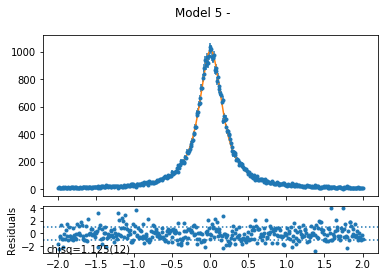

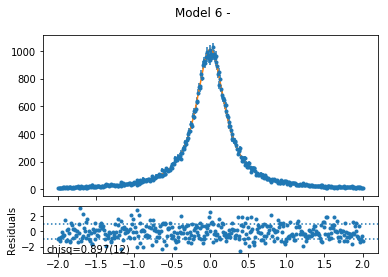

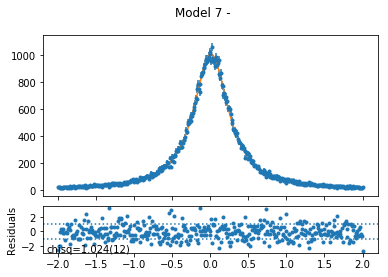

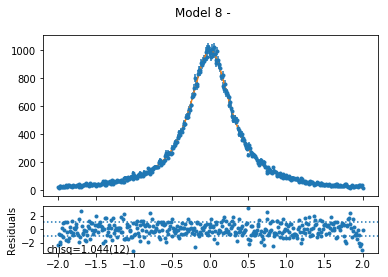

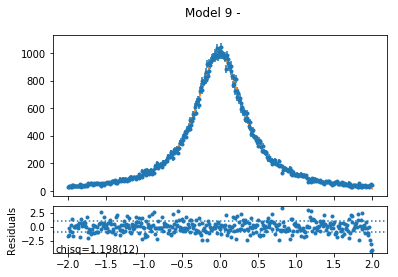

In [9]:
%run -m bumps.cli $model_file --fit=$minimiser --steps=$steps --store=$output_folder

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

In [7]:
# DISPLAY SOME RESULTS (Bumps output)
par_file = os.path.splitext(model_file)[0] + '.par'
err_file = os.path.splitext(model_file)[0] + '.err'

with open(os.path.join('.', output_folder, par_file), 'r') as fid:
    for line in fid:
        parameter, value = line.split()
        print(parameter, value)
        
with open(os.path.join(os.getcwd(), output_folder, err_file), 'r') as ferr:
    for line in ferr:
        print(line.rsplit('\n')[0])

A0 0.302386403380633
center 0.00199295649586005
hwhm 0.0052780247285524
scale 111.057048492927
center -0.000533349978283275
hwhm 0.020821620169306
scale 135.403545031317
center -0.00105802142875113
hwhm 0.0486054287750183
scale 166.098971006462
center -0.00219849099844366
hwhm 0.0853881233338711
scale 200.407272942772
center -0.00128746971083516
hwhm 0.137129893754846
scale 233.517802017739
center -0.00133468497286817
hwhm 0.192058147134583
scale 256.513240257754
center 0.000505457669712497
hwhm 0.269227166654584
scale 271.530528764068
center 0.00499958432702096
hwhm 0.363274863970245
scale 292.142101497278
center 0.000105862559098226
hwhm 0.448718729158565
scale 297.886024661339
center 0.000153521089264548
hwhm 0.55274451678609
scale 308.962781642539
-- Model 0 
.A0 = Parameter(0.302386, name='A0', bounds=(0,1))
.center = Parameter(0.00199296, name='center', bounds=(-0.1,0.1))
.hwhm = Parameter(0.00527802, name='hwhm', bounds=(0,2))
.q = Parameter(0.2, name='q')
.scale = Parameter(111

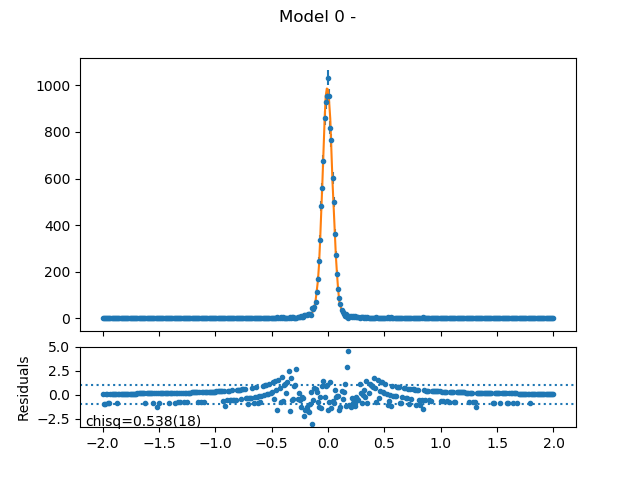

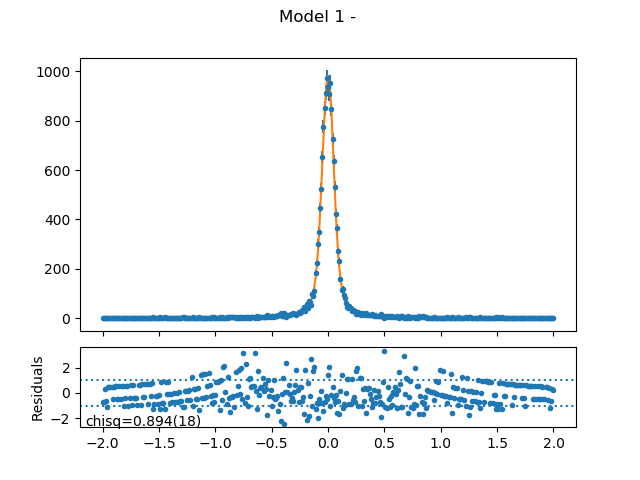

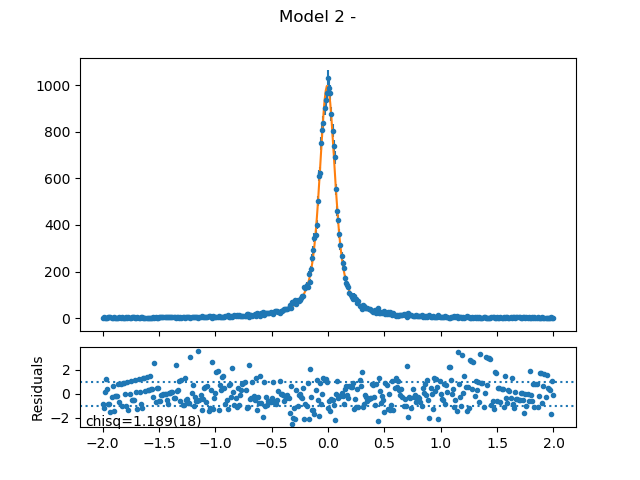

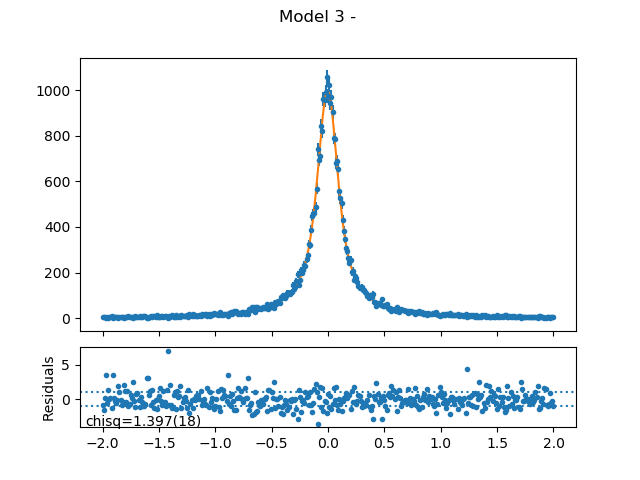

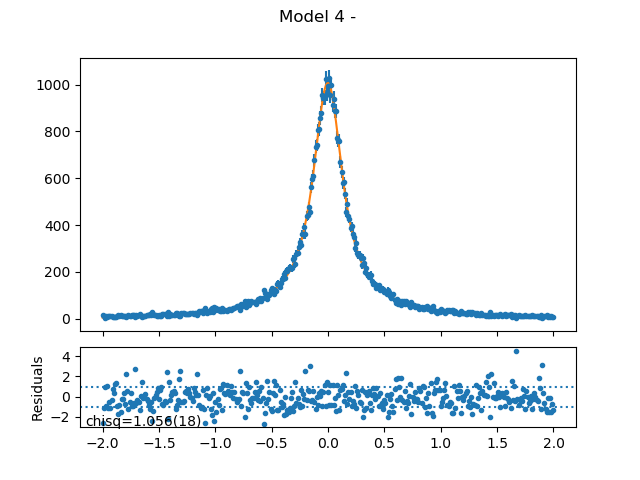

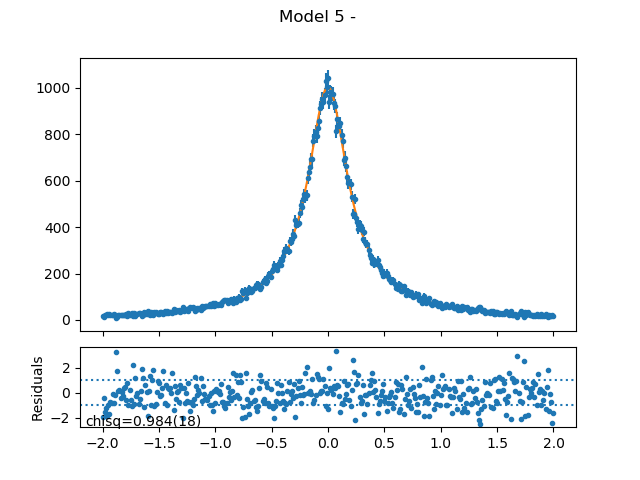

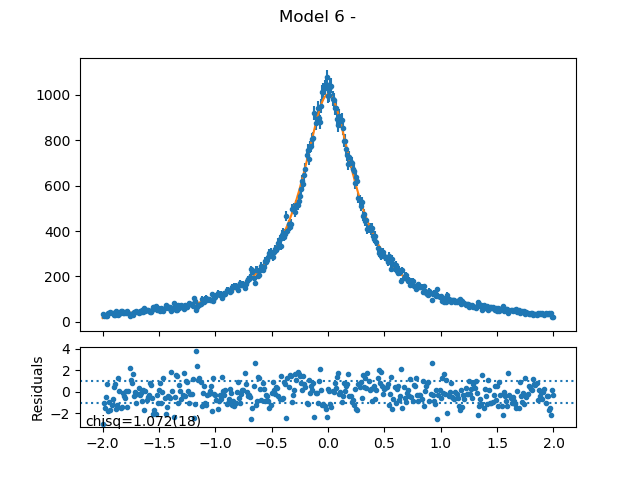

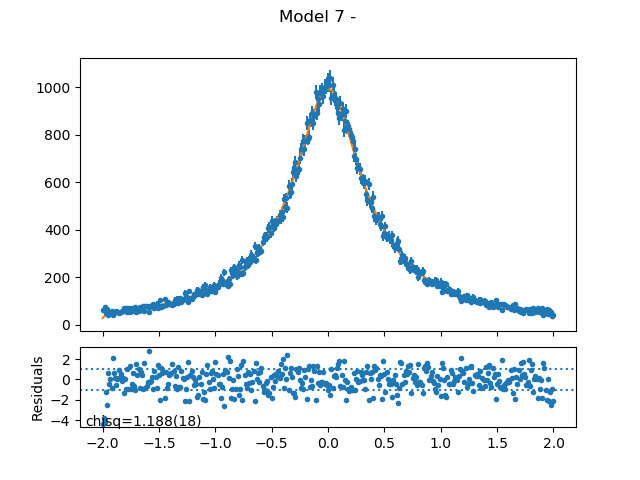

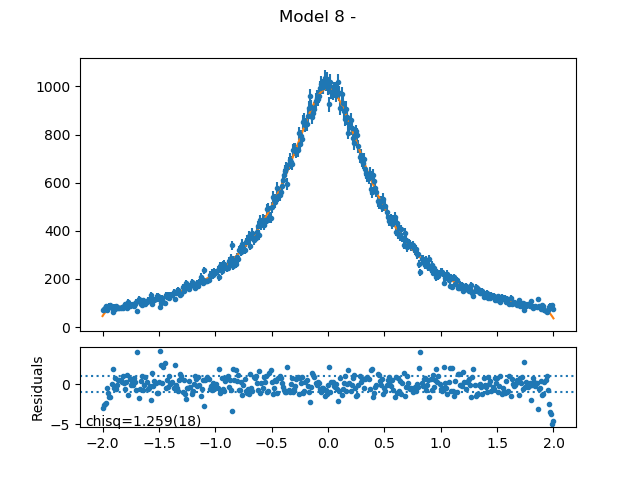

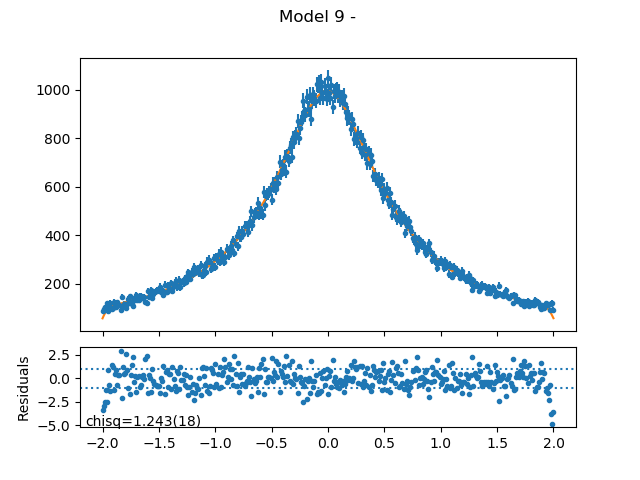

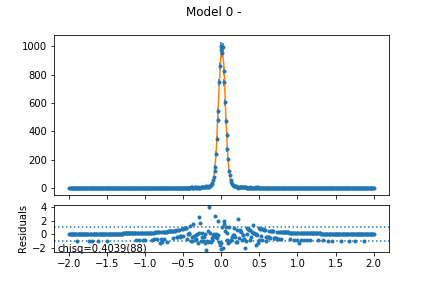

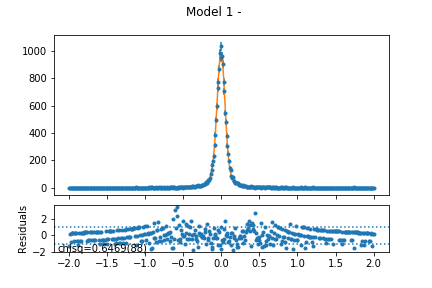

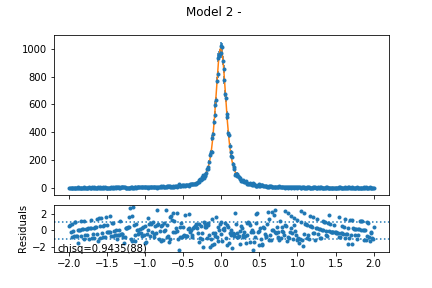

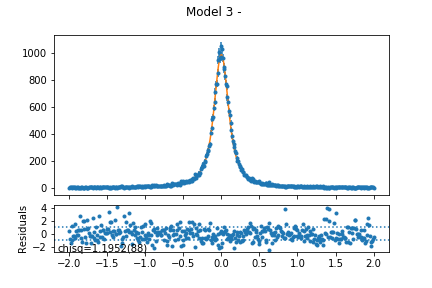

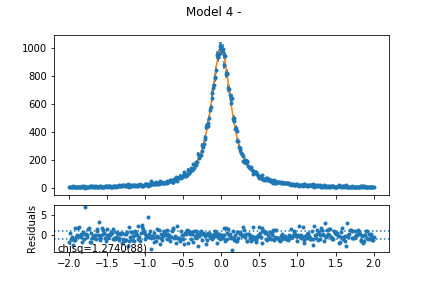

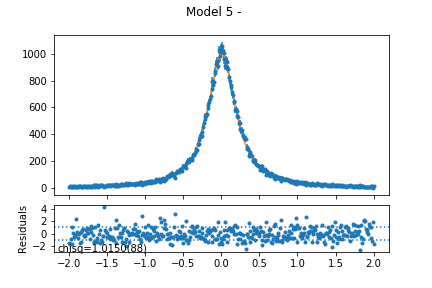

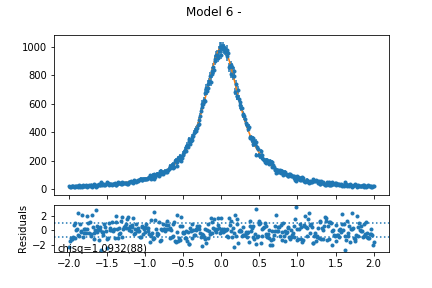

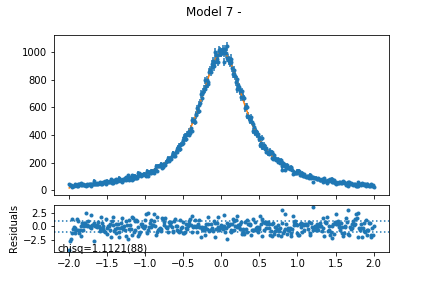

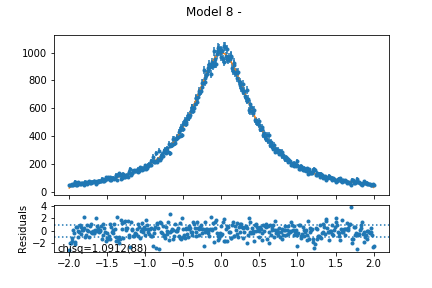

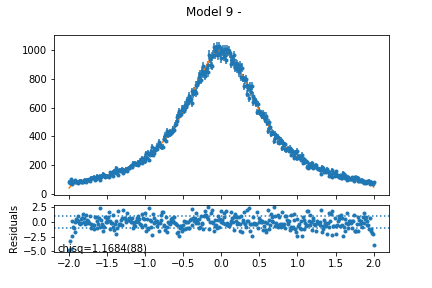

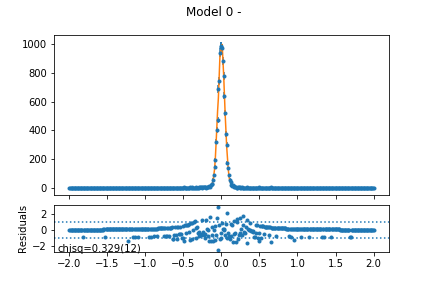

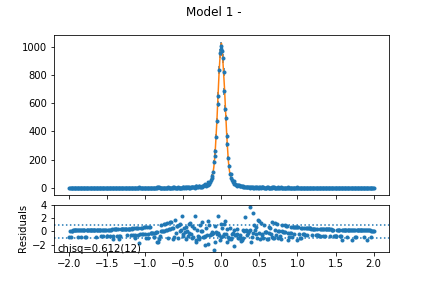

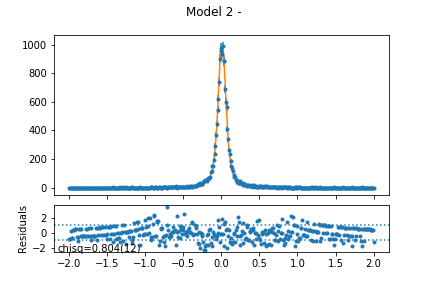

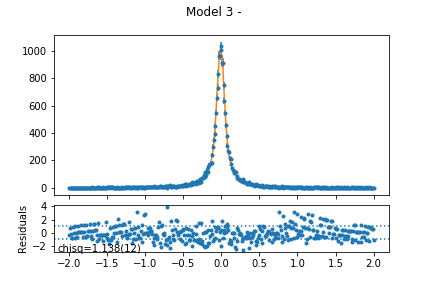

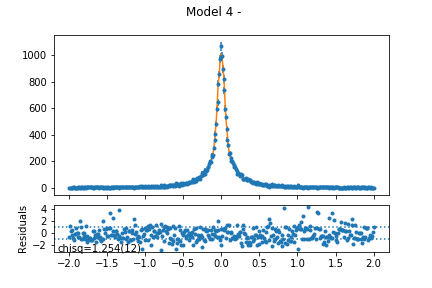

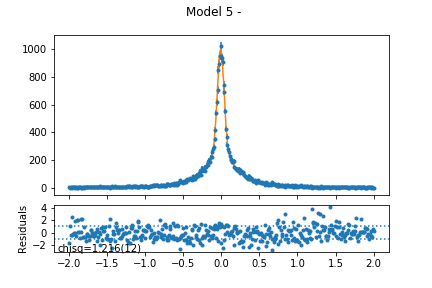

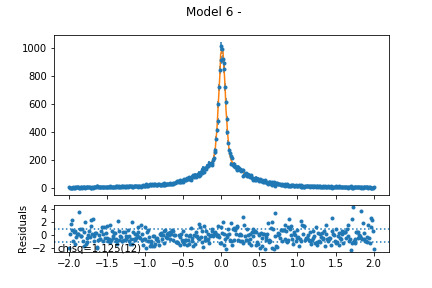

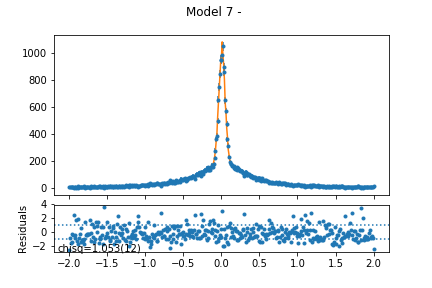

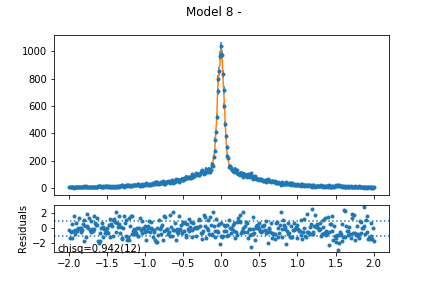

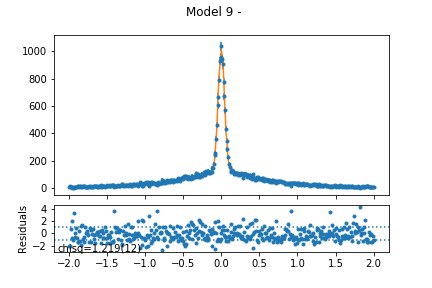

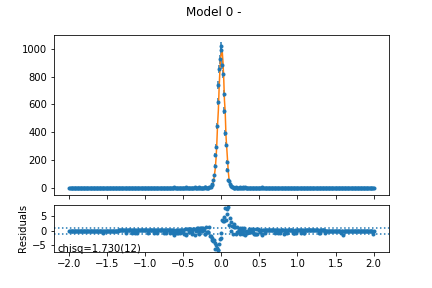

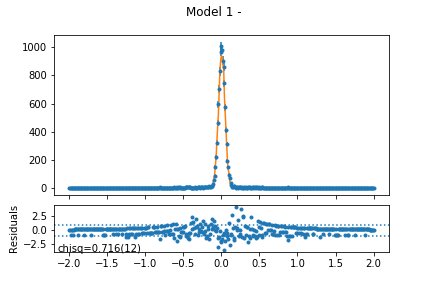

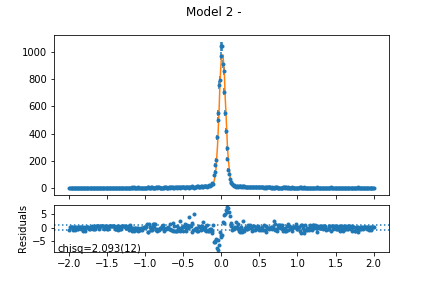

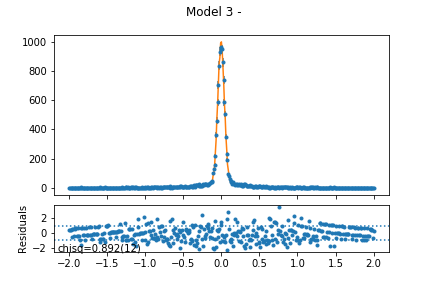

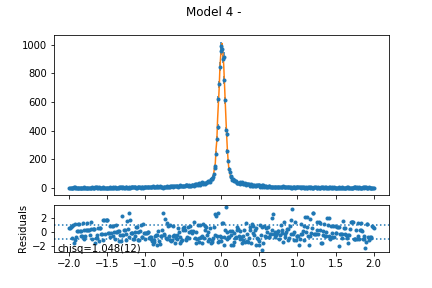

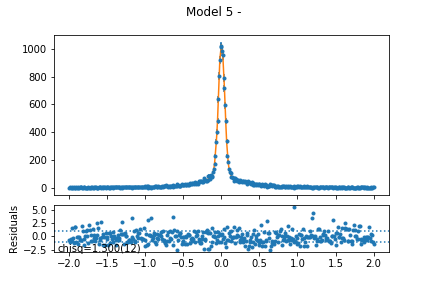

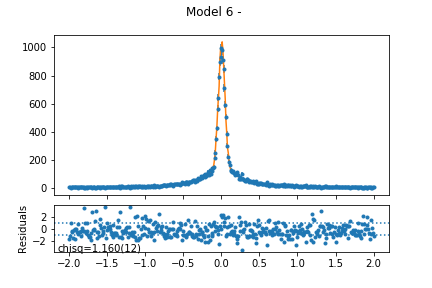

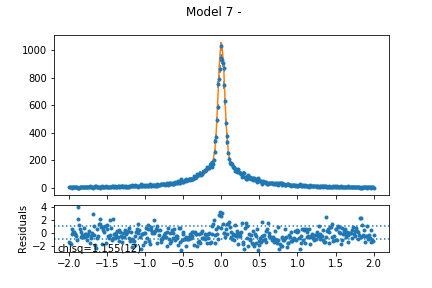

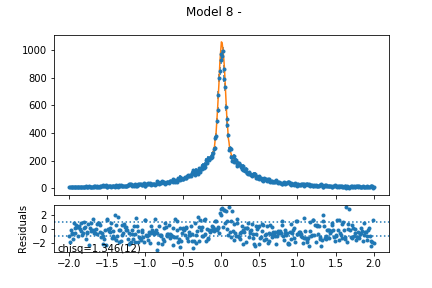

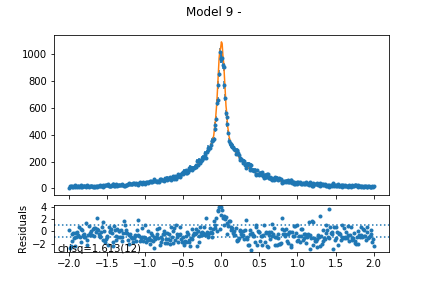

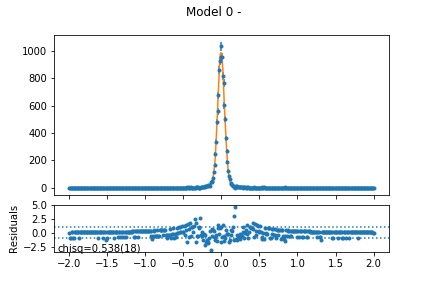

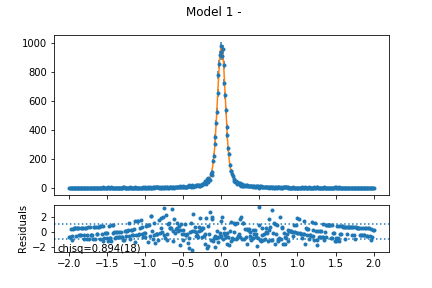

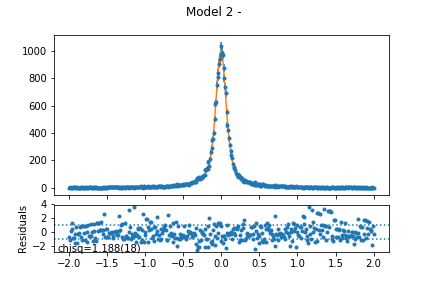

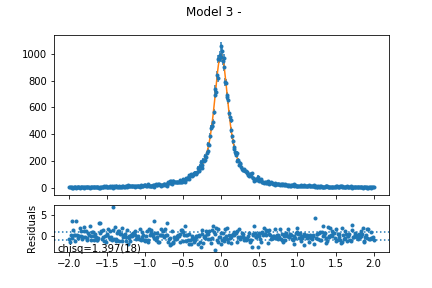

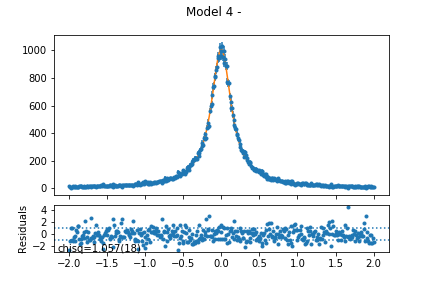

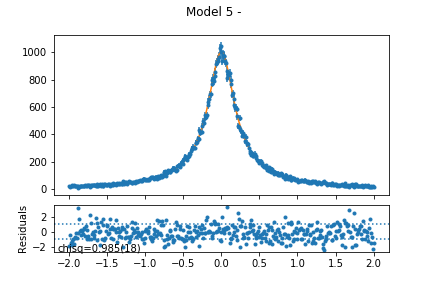

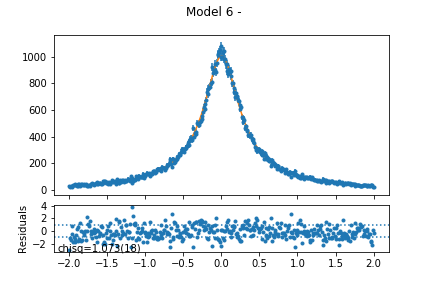

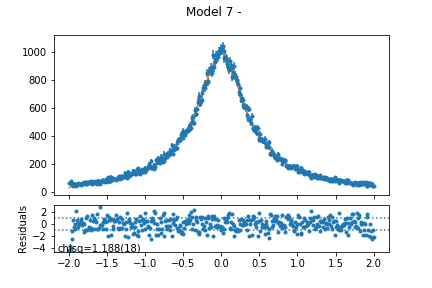

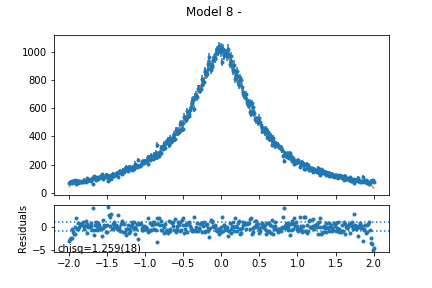

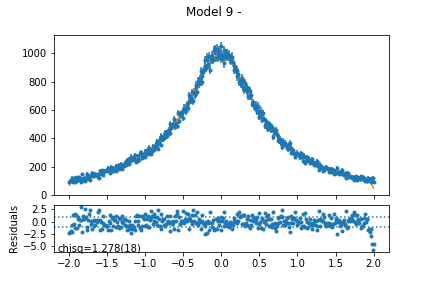

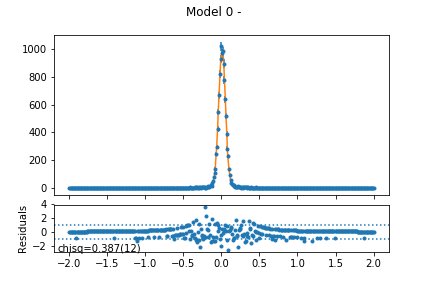

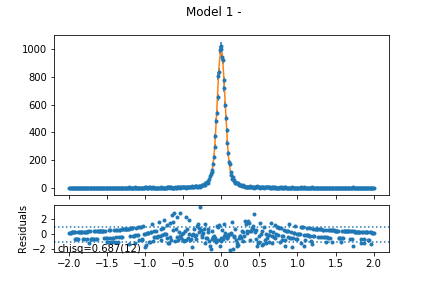

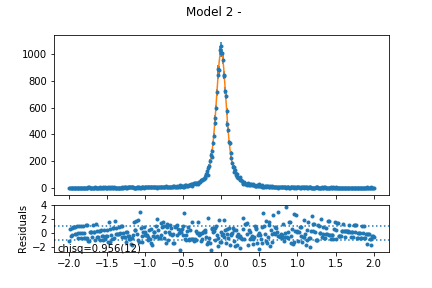

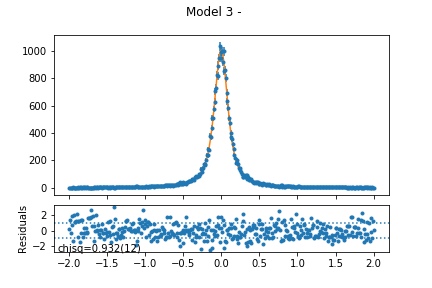

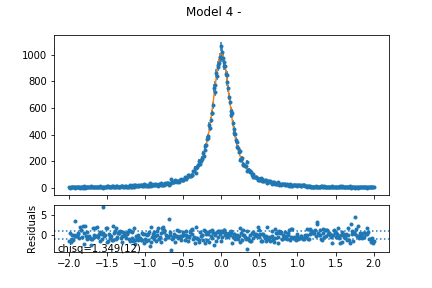

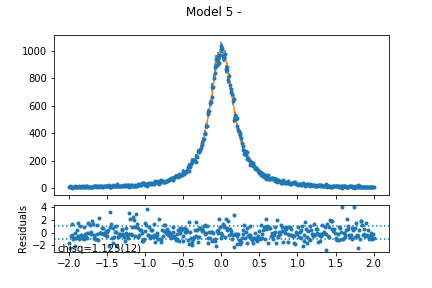

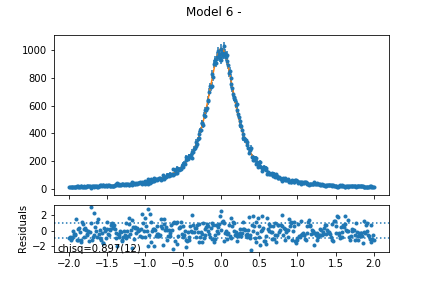

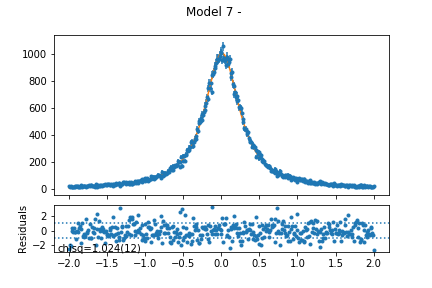

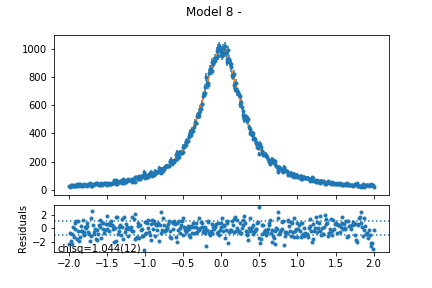

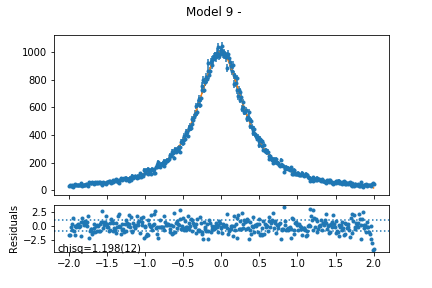

In [10]:
# Plot the fitting results

from IPython.display import display, Image
relative_output_path = os.path.join('.', output_folder)
names = [f for f in os.listdir(relative_output_path) if f.endswith('.png')]

for name in names:
    display(Image(os.path.join(relative_output_path, name)))